In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Differences in trajectories

Check the difference in the trajectories between the robot and our agent when our agent can only choose randomly between continue, left or right. Both the robot and the agent make choices randomly.

Main differences:
- Our agent: 
    - For "continue": walks straight in the same direction (no reorientation).
    - For "turning" actions: uniform distribution in the left and right areas (areas of 120 degrees to the left and right or current orientation). 
    - When it turns, it reorients + it walks for a distance agent_step.
- Robot: 
    - For "continue": walks straight in the same direction (no reorientation) for a distance $v$ sampled from a normal distribution. $N(\alpha, \sigma_\alpha)$
    - For "turning" actions: normal distribution centered on some angle to the left or to the right. $N(\beta, \sigma_\beta)$
    - When it turns, it just reorients (NO EXTRA DISPLACEMENT). The reorientation occurs with respect to a center that is on the side wheels (the ones that don't move), so (in contrast to our ideal agent) it also displaces its position a little bit when it reorients.

In [ ]:
def update_pos_robot(turn, current_theta, current_x, current_y, beta, beta_sig, alpha, alpha_sig, rad=1, L=100):

    if turn:
        a = np.random.rand()
        if (a < .5): #right turn
            dtheta = - np.random.normal(beta, beta_sig)
        else: #left turn
            dtheta = np.random.normal(beta, beta_sig)
        
        
        # Update the rotation of the agent
        agents_theta = current_theta + dtheta
        
        # Get the positional changes
        dx = np.sign(dtheta) * rad * (np.sin(agents_theta) - np.sin(current_theta));
        dy = - np.sign(dtheta) * rad * (np.cos(agents_theta) - np.cos(current_theta));
    
    else: #Otherwise we continue straight forward
    
        #Update the velocity of the agent
        v = np.random.normal( max(0,alpha), max(0,alpha_sig));
        
        agents_theta = current_theta
        
        # Get the positional changes
        dx = v * np.cos(agents_theta);
        dy = v * np.sin(agents_theta);
    
    # Update the position with fixed boundary conditions
    agents_x = max( 0, min( current_x + dx, L ) );
    agents_y = max( 0, min( current_y + dy, L ) );
    
    return agents_theta, agents_x, agents_y

In [ ]:
def update_pos_our_agent(action, current_theta, current_x, current_y, agent_step = 1, L = 100):        
    """
    Updates information of the agent depending on its decision.

    Parameters
    ----------
    action : int
        0 (continue), 1 (left), 2 (right), 3 (back).
    agent_index : int, optional
        Index of the given agent. The default is 0.
    """
    
    
    if action == 0: #if agent continues, it does not change its direction.
        pass
    elif action == 1: #left
        current_theta += random.uniform(0,1)*2*np.pi/3
    elif action == 2: #right
        current_theta -= random.uniform(0,1)*2*np.pi/3
    elif action == 3: #back
        current_theta += 2*np.pi/3 + random.uniform(0,1)*2*np.pi/3
    else:
        print('This action value is not defined')
        
    #Update position
    agents_x = current_x + agent_step*np.cos(current_theta)
    agents_y = current_y + agent_step*np.sin(current_theta)
    
    # Update the position with fixed boundary conditions
    agents_x = max( 0, min( agents_x, L ) );
    agents_y = max( 0, min( agents_y, L ) );
    
    return current_theta, agents_x, agents_y

<matplotlib.legend.Legend>

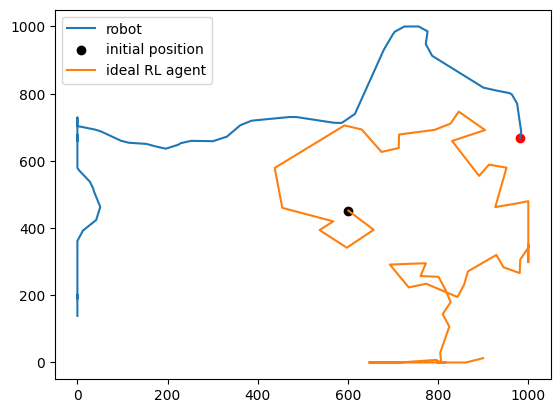

In [ ]:
# Parameters
L = 1000
n_steps = 100

beta = 0.5
beta_sig = 0.3
alpha = 40
alpha_sig = 5
rad = 40

# Initialize robot

current_theta = np.random.rand() * 2 * np.pi
current_x = np.random.rand() * L
current_y = np.random.rand() * L

# Initialize our agent
agent_step = 40
current_theta_ours = np.random.rand() * 2 * np.pi
current_x_ours = np.random.rand() * L
current_y_ours = np.random.rand() * L

# Initialize storage of trajectories

traj = np.zeros((n_steps,2))

traj_our_ag = np.zeros((n_steps,2))

# Walk

for step in range(n_steps):
    
    decision = np.random.rand()
    turn = (True if decision < 0.5 else False)
    
    current_theta, current_x, current_y = update_pos_robot(turn, current_theta, current_x, current_y, beta, beta_sig, alpha, alpha_sig, rad=rad, L=L)
    traj[step] = np.array ([current_x, current_y])
    
    action = np.random.choice(np.arange(3))
    current_theta_ours, current_x_ours, current_y_ours = update_pos_our_agent(action, current_theta_ours, current_x_ours, current_y_ours, agent_step = agent_step, L = L)
    traj_our_ag[step] = np.array ([current_x_ours, current_y_ours])

plt.scatter(traj[0,0], traj[0,1], color='red')
plt.plot(traj[:,0], traj[:,1], label='robot')

plt.scatter(traj_our_ag[0,0], traj_our_ag[0,1], color='black',label='initial position')
plt.plot(traj_our_ag[:,0], traj_our_ag[:,1],label='ideal RL agent')

plt.legend()

# Check rotations with offset

Check that the left and right reorientations of the robot are actually to the left and to the right. We check four different initial orientations $\theta$ of the robot, where $\theta$ is an angle in the first quadrant, the second, the third and the fourth. The rotation angle is set to $d\theta = \pi/3$.

## Function for final coordinates after offset rotation

In [ ]:
def rotated_coord(theta, dtheta, R=1):        
    # Update the rotation of the agent
    new_theta = theta + dtheta

    # Get the positional changes
    dx = np.sign(dtheta) * R * (np.sin(new_theta) - np.sin(theta));
    dy = - np.sign(dtheta) * R * (np.cos(new_theta) - np.cos(theta));
    
    return [dx, dy]

## Function to get the rotation arc

In [ ]:
def rotation_arc(theta, dtheta, left, num_points_arc=100, R=1, x=0, y=0):
    
    if left:
        value = 1
        sum_angle = 0
    else:
        value = -1
        sum_angle = np.pi
    
    phi = np.pi / 2 - theta
    
    # Get origin of rotation
    origin_x = x - value * R * np.cos(phi)
    origin_y = y + value * R * np.sin(phi)
    
    # Generate points for the arc in rad: from start point to final point = start point + length of arc
    start_angle = sum_angle - phi
    angles = np.linspace(start_angle, start_angle + dtheta, num_points_arc)
    x = origin_x + R * np.cos(angles) #x positions of all the arc points
    y = origin_y + R * np.sin(angles) #y positions of all the arc points
    
    return origin_x, origin_y, x, y

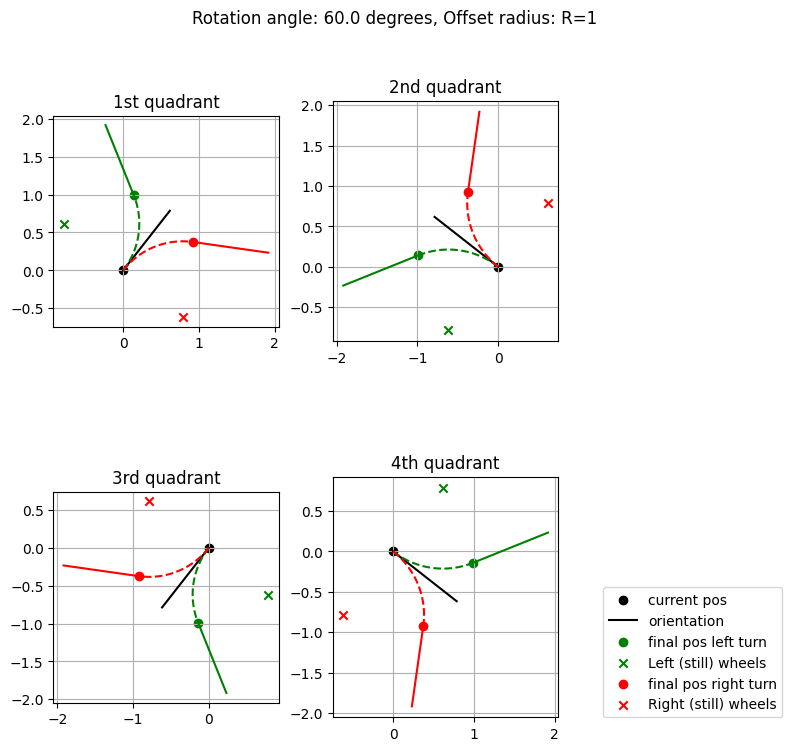

In [ ]:

#Define rotation angle
dtheta = np.pi/3

# Create a figure with 4 subplots (2x2 grid)
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# List of subplot titles
titles = ["1st quadrant", "2nd quadrant", "3rd quadrant", "4th quadrant"]

# Loop through each subplot
theta_example = np.random.rand() * np.pi/2

for i in range(4):
    ax = axs[i // 2, i % 2]  # Access the i-th subplot
    
    #get theta in the corresponding quadrant
    theta_i = theta_example + i*np.pi/2
    
    #get coordinates of current position:
    [x_i, y_i] = [np.cos(theta_i), np.sin(theta_i)]
    ax.scatter(0, 0, color='black', label='current pos') #point
    ax.plot([0,x_i], [0,y_i], color='black', label='orientation') #orientation direction
    
    #point to the left
    [dx_L, dy_L] = rotated_coord(theta_i, dtheta)
    ax.scatter(dx_L, dy_L, color='green', label='final pos left turn') #point
    ax.plot([dx_L, dx_L + np.cos(theta_i + dtheta)], [dy_L, dy_L + np.sin(theta_i + dtheta)], color='green') #orientation direction
    #arc to the left
    ox_L, oy_L, arc_x_L, arc_y_L = rotation_arc(theta_i, dtheta, left=True)
    ax.plot(arc_x_L, arc_y_L, '--', color='green')
    ax.scatter(ox_L, oy_L, color='green', marker='x', label='Left (still) wheels')
    
    #point to the right
    [dx_R, dy_R] = rotated_coord(theta_i, - dtheta)
    ax.scatter(dx_R, dy_R, color='red', label='final pos right turn') #point
    ax.plot([dx_R, dx_R + np.cos(theta_i - dtheta)], [dy_R, dy_R + np.sin(theta_i - dtheta)], color='red') #orientation direction
    #arc to the right
    ox_R, oy_R, arc_x_R, arc_y_R = rotation_arc(theta_i, - dtheta, left=False)
    ax.plot(arc_x_R, arc_y_R, '--', color='red')
    ax.scatter(ox_R, oy_R, color='red', marker='x', label='Right (still) wheels')
    
    #plot params
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(titles[i])
    ax.grid(True)
    
ax.legend(loc=[1.2,0])

# Set the overall title and show the plot
plt.suptitle(f'Rotation angle: {np.round(dtheta * 180/np.pi,2)} degrees, Offset radius: R=1')
plt.tight_layout()
plt.show()

# Turning arc within target

Function to check whether the turning arc is within a target area. Experimentally, the target is an area with light. Thus, it is easier to continuously check whether the light sensor of the robot is activated or not while it walks.

In [ ]:
target_coord = np.array([0, -0.5])
target_radius = 0.5
in_target = (arc_x_R - target_coord[0])**2 + (arc_y_R - target_coord[1])**2 <= target_radius**2

In [ ]:
np.shape(arc_x_R)

(100,)

<matplotlib.legend.Legend>

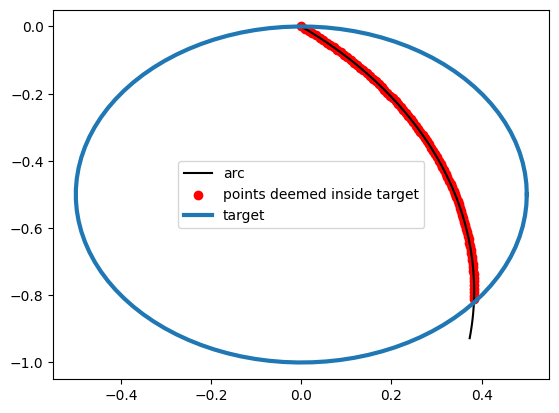

In [ ]:
plt.figure()
#plot arc
plt.plot(arc_x_R, arc_y_R, color='black', label='arc')
#plot points in arc that are deemed to be within the target
for i, is_point_in in enumerate(in_target):
    if is_point_in:
        plt.scatter(arc_x_R[i], arc_y_R[i], color='red', marker='o',label=('points deemed inside target' if i==0 else None))
        
#target circle
# Generate points for the circle
an = np.linspace(0, 2 * np.pi, 100)  # 100 points from 0 to 2*pi
x_target = target_coord[0] + target_radius * np.cos(an)  # x = R*cos(theta)
y_target = target_coord[1] + target_radius * np.sin(an)  # y = R*sin(theta)

# Create the plot
plt.plot(x_target, y_target, linewidth = 3, label='target')
plt.legend()

## Function arc_in_target

In [ ]:
def arc_in_target(target_coord, target_radius, theta, dtheta, left, num_points_arc=20, R=1, x=0, y=0):
    """
    target_coord: array with all the coordinates of all the targets.
    """
    _,_, x_arc, y_arc = rotation_arc(theta, dtheta, left, num_points_arc = num_points_arc, R = R, x = x, y = y)
    
    # Reshape the arc arrays to make them broadcastable
    x_arc_broadcasted = x_arc[:, np.newaxis]  # Shape (num_points_arc, 1)
    y_arc_broadcasted = y_arc[:, np.newaxis]  # Shape (num_points_arc, 1)

    # Compute the squared distances from all arc points to all target centers
    distances_squared = (x_arc_broadcasted - target_coord[:, 0])**2 + (y_arc_broadcasted - target_coord[:, 1])**2

    # Check if these distances are within the target radius squared
    mask_in_target = distances_squared <= target_radius**2

    # Summing over the arc points axis (axis=0), find which targets are found
    mask_found_targets = np.sign(np.sum(mask_in_target, axis=0))
    
    return mask_found_targets, x_arc, y_arc


In [ ]:
Nt = 20
L = 10
target_r = 1
all_targets = np.random.rand(Nt, 2)* L

found, arc_x, arc_y = arc_in_target(all_targets, target_r, np.pi/6, np.pi/3, True, num_points_arc=20, R=1, x=0, y=0)

In [ ]:
print('Indices of found targets')
np.where(found == True)[0]

Indices of found targets


array([9], dtype=int64)

In [ ]:
all_targets[np.where(found == True)[0]]

array([[0.56760876, 0.44922735]])

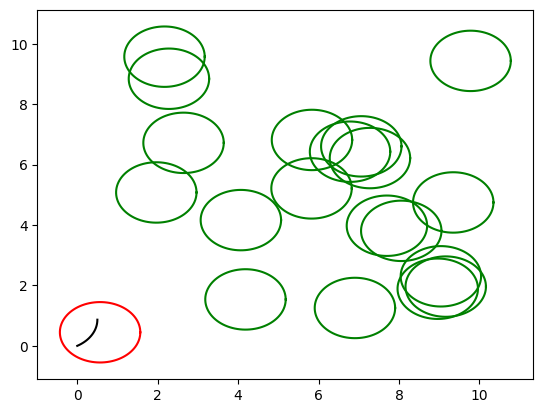

In [ ]:
plt.figure()
#plot arc
plt.plot(arc_x, arc_y, color='black')
  
#target circles
# Generate points for the circle
an = np.linspace(0, 2 * np.pi, 100)  # 100 points from 0 to 2*pi
for i, coord in enumerate(all_targets):
    x_target = coord[0] + target_r * np.cos(an)  # x = R*cos(theta)
    y_target = coord[1] + target_r * np.sin(an)  # y = R*sin(theta)

    # Create the plot
    if i in np.where(found == 1)[0]:
        plt.plot(x_target, y_target, color = 'red') #found targets are depicted in red
    else:
        plt.plot(x_target, y_target, color = 'green')
    


In [ ]:
%timeit arc_in_target(all_targets, target_r, np.pi/6, np.pi/3, True, num_points_arc=50, R=1, x=0, y=0)

74.9 µs ± 843 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
import numba
from numba.experimental import jitclass
from numba import jit, float64, int64, bool_, prange, njit
NOPYTHON = True

In [ ]:
@jit(nopython = NOPYTHON)
def arc_in_target_numba(target_coord, target_radius, theta, dtheta, left, num_points_arc=20, R=1, x=0, y=0):
    """
    target_coord: array with all the coordinates of all the targets.
    """
    
    if left:
        value = 1
        sum_angle = 0
    else:
        value = -1
        sum_angle = np.pi

    phi = np.pi / 2 - theta

    # Get origin of rotation
    origin_x = x - value * R * np.cos(phi)
    origin_y = y + value * R * np.sin(phi)

    # Generate points for the arc in rad: from start point to final point = start point + length of arc
    start_angle = sum_angle - phi
    angles = np.linspace(start_angle, start_angle + dtheta, num_points_arc)
    x_arc = origin_x + R * np.cos(angles) #x positions of all the arc points
    y_arc = origin_y + R * np.sin(angles) #y positions of all the arc points

    # Reshape the arc points to make them compatible for broadcasting
    x_arc = x_arc[:, np.newaxis]  # Shape (number of targets, 1)
    y_arc = y_arc[:, np.newaxis]  # Shape (number of targets, 1)

    # Compute the squared distances from all arc points (rows) to all target centers (columns)
    distances_squared = (x_arc - target_coord[:, 0])**2 + (y_arc - target_coord[:, 1])**2

    # Check if these distances are within the target radius squared
    mask_in_target = distances_squared <= target_radius**2

    # Summing over the arc points axis (axis=0), find which targets are found
    mask_found_targets = np.sign(np.sum(mask_in_target, axis=0))
    
    return mask_found_targets

In [ ]:
targ = np.random.rand(100, 2)* 100
compile_first = arc_in_target_numba(targ, target_r, np.pi/6, np.pi/3, True, num_points_arc=50, R=1, x=0, y=0)

In [ ]:
%timeit arc_in_target_numba(targ, target_r, np.pi/6, np.pi/3, True, num_points_arc=50, R=1, x=0, y=0)

8.96 µs ± 6.43 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [ ]:
np.shape(found)

(20,)